# Weather prediction example

This notebook shows a advanced way to predict time series data using a PredictLite neural network

(c) Mikko Kursula 2022. MIT License. 

In [1]:
# Enable automatic reloading (if changes are done in the model code)
%load_ext autoreload
%autoreload 2

# General
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Data source
import meteostat

# PredictLite
from predictlite.predictlite import PredictLite

### Get weather dataset

In [2]:
# Get hourly weather data
station_id = '02944'
start_dt = datetime(2017, 1, 1)
end_dt = datetime(2022, 1, 1)
dataset = meteostat.Hourly(station_id, start_dt, end_dt).fetch()
dataset.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2017-01-01 00:00:00,0.1,-3.1,79.0,NaN,NaN,230.0,13.0,NaN,996.5,NaN,NaN
2017-01-01 01:00:00,-0.5,-2.9,84.0,NaN,NaN,230.0,14.8,NaN,996.4,NaN,NaN
2017-01-01 02:00:00,0.0,-2.2,85.0,NaN,NaN,220.0,9.4,NaN,996.6,NaN,NaN
2017-01-01 03:00:00,-2.2,-3.6,90.0,NaN,NaN,230.0,13.0,NaN,996.6,NaN,NaN
2017-01-01 04:00:00,-3.2,-4.2,93.0,NaN,NaN,240.0,11.2,NaN,996.8,NaN,NaN


### Create categorical features
This example creates precipitation category with binary values raining/not raining.

In [3]:
dataset['prcp'] = dataset['prcp'].fillna(0)
dataset['prcp_cat'] = (dataset['prcp'] > 0).astype(str)

### Setup and train PredictLite model 

In [4]:
model = PredictLite(
    input_signals=['temp', 'rhum'], 
    input_preprocessing={'temp' : 'z-norm', 'rhum' : 'z-norm'},
    input_length=72,
    datetime_embeddings=['month', 'hour'],
    categorical_inputs=['prcp_cat'],
    output_signals=['temp', 'rhum'],
    output_length=24,
    data_sample_period=3600,
    hidden_layer_n=2,
)

model.fit(
    dataset,
    train_sample_n=10000,
    test_sample_n=1000,
    epochs=20,
    random_seed=13,
    verbose=True,
)

Setting up preprocessing
Building dataset
Training the model
epoch:   0, train loss: 0.53093, test loss: 0.30537
epoch:   1, train loss: 0.26821, test loss: 0.24738
epoch:   2, train loss: 0.24170, test loss: 0.23082
epoch:   3, train loss: 0.23030, test loss: 0.22121
epoch:   4, train loss: 0.22210, test loss: 0.21684
epoch:   5, train loss: 0.21653, test loss: 0.21185
epoch:   6, train loss: 0.21250, test loss: 0.21166
epoch:   7, train loss: 0.20963, test loss: 0.20720
epoch:   8, train loss: 0.20607, test loss: 0.20593
epoch:   9, train loss: 0.20362, test loss: 0.20628
epoch:  10, train loss: 0.20095, test loss: 0.20507
epoch:  11, train loss: 0.19840, test loss: 0.20458
epoch:  12, train loss: 0.19779, test loss: 0.20413
epoch:  13, train loss: 0.19555, test loss: 0.20446
epoch:  14, train loss: 0.19358, test loss: 0.20282
epoch:  15, train loss: 0.19196, test loss: 0.20523
epoch:  16, train loss: 0.19165, test loss: 0.20383
epoch:  17, train loss: 0.18977, test loss: 0.20170
epo

In [6]:
# Continue training
model.fit(
    data=dataset,
    train_sample_n=5000,
    test_sample_n=1000,
    epochs=20,
    random_seed=313,
    verbose=True,
    fit_existing_model=True,
)

Building dataset
Training the existing model
epoch:   0, train loss: 0.16857, test loss: 0.19846
epoch:   1, train loss: 0.16798, test loss: 0.19388
epoch:   2, train loss: 0.16790, test loss: 0.19461
epoch:   3, train loss: 0.16650, test loss: 0.19356
epoch:   4, train loss: 0.16904, test loss: 0.20026
epoch:   5, train loss: 0.16532, test loss: 0.19419
epoch:   6, train loss: 0.16453, test loss: 0.19584
epoch:   7, train loss: 0.16396, test loss: 0.19450
epoch:   8, train loss: 0.16324, test loss: 0.19420
epoch:   9, train loss: 0.16273, test loss: 0.19383
epoch:  10, train loss: 0.16089, test loss: 0.19444
epoch:  11, train loss: 0.15911, test loss: 0.19512
epoch:  12, train loss: 0.15955, test loss: 0.19479
epoch:  13, train loss: 0.16037, test loss: 0.19887
epoch:  14, train loss: 0.15873, test loss: 0.19810
epoch:  15, train loss: 0.15747, test loss: 0.19744
epoch:  16, train loss: 0.15606, test loss: 0.19571
epoch:  17, train loss: 0.15678, test loss: 0.19524
epoch:  18, train l

In [7]:
model.model_summary()

Inputs:
	temp: 72
	rhum: 72
	month: Embedding(13, 20)
	hour: Embedding(25, 20)
	prcp_cat: Embedding(3, 20)
MLP:
	Linear(in_features=204, out_features=204, bias=True)
	ReLU()
	Linear(in_features=204, out_features=204, bias=True)
	ReLU()
	Linear(in_features=204, out_features=48, bias=True)
Outputs:
	temp: 24
	rhum: 24


### Make prediction

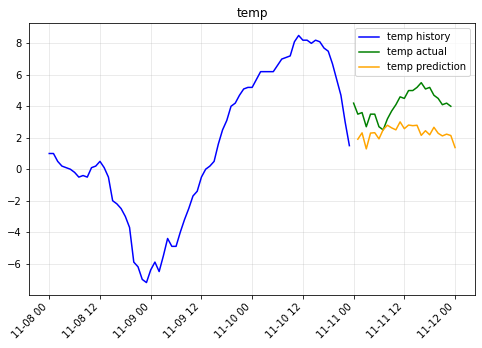

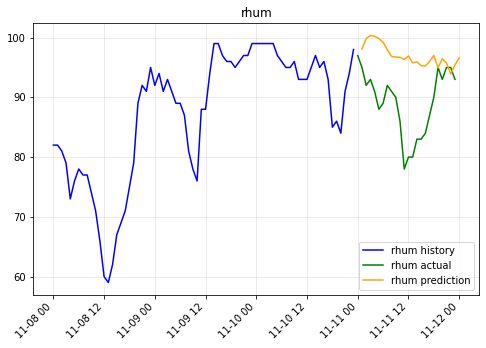

In [8]:
# Datetime for prediction start
prediction_time = datetime(2021, 11, 11, 0)

# Make prediction 
pred = model.predict(dataset, prediction_time)

# Plot data and prediction
pred_len = model.output_length
inp_len = model.input_length
for col in model.output_signals:
    
    ts_idx = dataset.index.get_loc(prediction_time, method='pad')
    plt.figure(figsize=(8, 5))
    plt.plot(
        dataset.index[ts_idx - inp_len : ts_idx].values, 
        dataset.iloc[ts_idx - inp_len : ts_idx][col].values, 
        color='blue', 
        label='{} history'.format(col)
    )
    plt.plot(
        dataset.index[ts_idx : ts_idx + pred_len].values, 
        dataset.iloc[ts_idx : ts_idx + pred_len][col].values, 
        color='green',
        label='{} actual'.format(col)
    )
    plt.plot(
        pred.index.values, 
        pred[col].values, 
        color='orange', 
        label='{} prediction'.format(col)
    )
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(col)
    plt.show()